#0.0 Install BaseMap Lib

In [1]:
!apt install proj-bin libproj-dev libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/refs/tags/v1.2.1rel.tar.gz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/refs/tags/v1.2.1rel.tar.gz


#0.1 Imports

In [2]:
# pacotes usados neste notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import datetime
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1.0 Frame the problem
Sao Paolo is the most populous state in Brazil and its State Capital, Sao Paolo City is the biggest city in Brazil and the 4th in entire world.
One between several economical market with relevant importancy in Sao Paulo City is its real state rental and sales market. Its numbers are quite impressive, reaching a sum of aproximately 20 billions reais in recent years [1].
Despite the world pandemic situation, real state market in Sao Paolo City kept its numbers ascending.[2]
Getting to know this market details and also extract some information from it that allows to predict house pricing seems to be reasonable and meaningful.


**References:**

[1] SECOVI SP, "Mercado imobiliário mantém resultados positivos em outubro", https://www.secovi.com.br/noticias/mercado-imobiliario-mantem-resultados-positivos-em-outubro/15088, (accessed on 2021-11-01).

[2] Honorio, Gustavo, G1, "https://g1.globo.com/sp/sao-paulo/noticia/2021/09/14/cidade-de-sao-paulo-bate-recorde-historico-de-venda-de-imoveis-em-meio-a-pandemia-especialista-ve-contradicao.ghtml", (accessed on 2021-11-01).

#1.1 Getting the data

In [3]:
df_raw_data = pd.read_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019.csv', sep=",")
df_raw_data.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


#1.1 Data attributes structure and meaning

In [4]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished         13640 non-null  int64  
 9   Swimming Pool     13640 non-null  int64  
 10  New               13640 non-null  int64  
 11  District          13640 non-null  object 
 12  Negotiation Type  13640 non-null  object 
 13  Property Type     13640 non-null  object 
 14  Latitude          13640 non-null  float64
 15  Longitude         13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memo

Data structure seems ok, no null values and the data type for each attribute seems fine as well.
The meaning of each data attribute are as follows:

* Price - Final price advertised (R$ Brazilian Real)
* Condo - Condominium expenses (unknown values are marked as zero)
* Size - The property size in Square Meters m² (private areas only)
* Rooms - Number of bedrooms
* Toilets - Number of toilets (all toilets)
* Suites - Number of bedrooms with a private bathroom (en suite)
* Parking - Number of parking spots
* Elevator - Binary value: 1 if there is elevator in the building, 0 otherwise
* Furnished - Binary value: 1 if the property is funished, 0 otherwise
* Swimming Pool - Binary value: 1 if the property has swimming pool, 0 otherwise
* New - Binary value: 1 if the property is very recent, 0 otherwise
* District - The neighborhood and city where the property is located, e.i: Itaim Bibi/São Paulo
* Negotiation Type - Sale or Rent
* Property Type - The property type
* Latitude - Geographic location
* Longitude - Geographic location

# 1.2 Data distribution
Histograms allow data checking regarding its distribution.

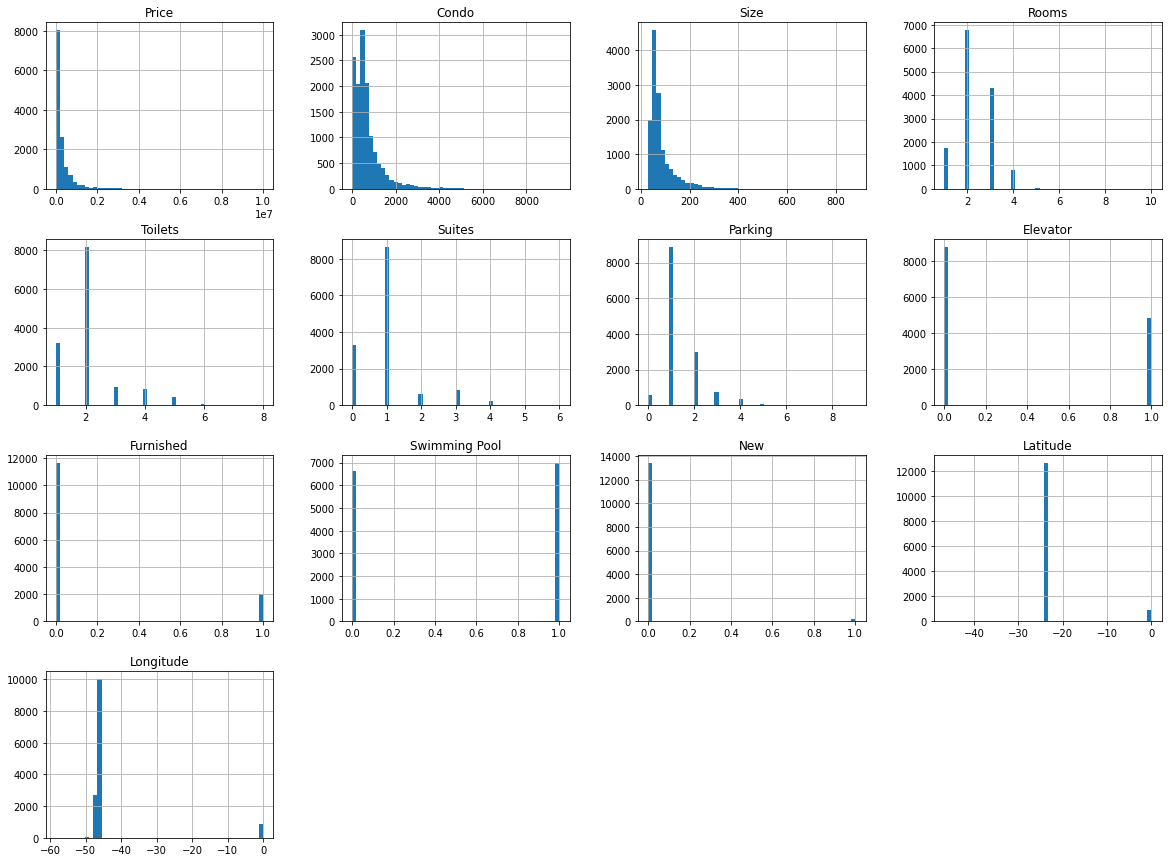

In [5]:
# plot a histogram for each numeric attibute from the dataframe
df_raw_data.hist(bins=50, figsize=(20,15))
display()  # just to avoid texts in the notebook output

Histogram suggestes that a data problem exists related to Latitude / Longitude information. It will be dealt later. 

#1.4 Check for duplicates

In [6]:
#check for duplicates
df_raw_data.duplicated().any()

True

# 1.4.1 Drop duplicated samples

In [7]:
#drop duplicates
df = df_raw_data.copy()
df = df.drop_duplicates()
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


#1.5 Exploratory Data Analysis
In order to get to know the dataset, lets dive into it and inspect attribues values, ranges and so on in order to collect some findings about its structure and meaning.

#1.5.1 Plot a map with geographical data.

In [8]:
def make_map():
    fig, ax = plt.subplots()
    m = Basemap(projection='merc', llcrnrlat=-50, urcrnrlat=20,
                llcrnrlon=-100, urcrnrlon=-10, resolution='i')
    m.ax = ax
    m.fillcontinents()
    return fig, m

In [9]:
def drawstates(ax, shapefile='/content/drive/MyDrive/IFSP/D2APR/shapefiles/BR/gadm36_BRA_1'):
        shp = m.readshapefile(shapefile, 'states', drawbounds=True)
        for nshape, seg in enumerate(m.states):
            poly = Polygon(seg, facecolor='0.75', edgecolor='k')
            ax.add_patch(poly)

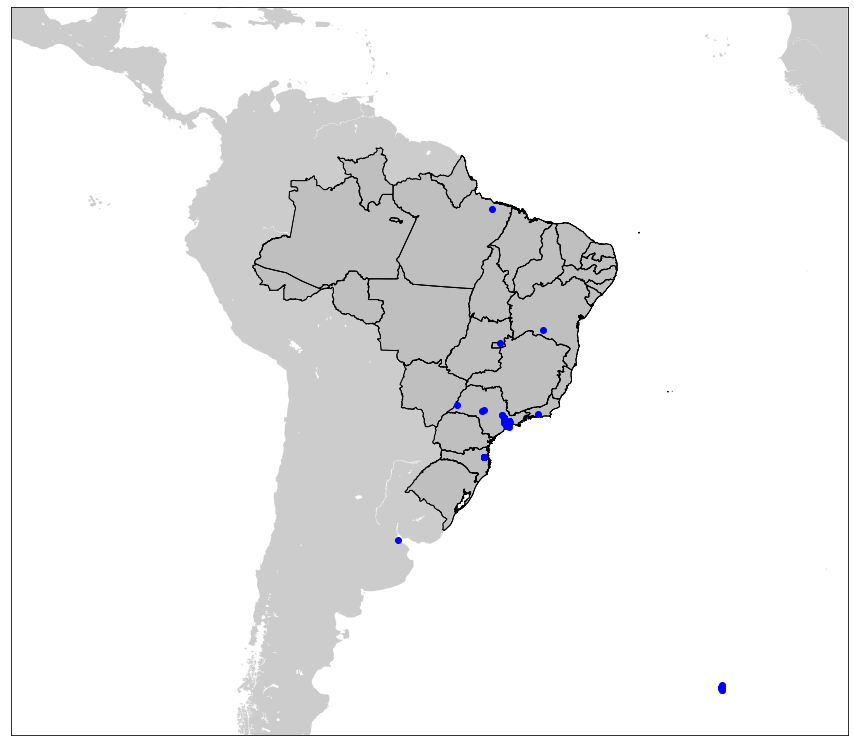

In [10]:
fig, m = make_map()
fig.set_size_inches(15,15)
x, y = m(df_raw_data['Longitude'], df_raw_data['Latitude'])
m.scatter(x, y, marker = 'o', color='b', zorder=3)
drawstates(m.ax)

As histrograms suggests, a geografical plot of this data evidences that some data cleaning is needed based on Latitude and Longitude attributes. Some data rows results on misplaced points.

#1.5.2 Plot the data (scatterplot)

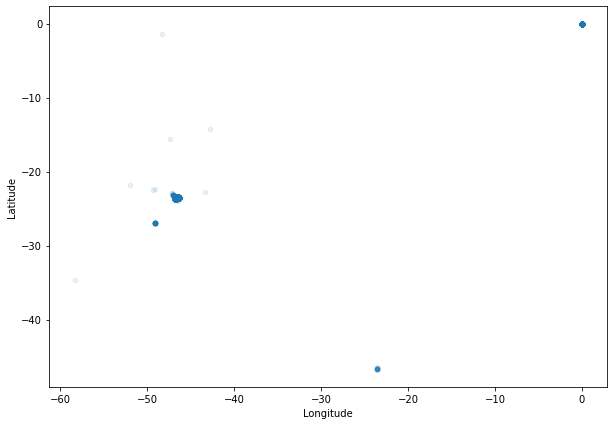

In [11]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, figsize=(10, 7))

#1.5.3 Sao Paolo city coordinates
Sao Paolo city limits are known and the coordinates of its extreme points are aproximately:

* SP East Longitude: -46.8247
* SP West Longitude: -46.3664
* SP North Latitude -23.3573
* SP South Latitude -24.0078


Based on the known coordinates above, data points must fullfill some caracteristics:
Longitude is always bigger than Latitude and they are limited as above.


In [12]:
df[df['Latitude'] < df['Longitude']]

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
1113,1300,637,50,2,2,1,1,1,0,0,0,Jabaquara/São Paulo,rent,apartment,-46.648904,-23.652027
1211,2200,500,30,1,2,1,1,1,0,1,0,Moema/São Paulo,rent,apartment,-46.655399,-23.607013
1583,2600,974,76,2,2,1,2,1,1,1,0,Alto de Pinheiros/São Paulo,rent,apartment,-46.715115,-23.540783
1792,1400,580,60,3,2,1,1,1,0,1,0,Jaguaré/São Paulo,rent,apartment,-46.749039,-23.545329
1937,4200,800,97,2,3,1,2,1,1,1,0,Perdizes/São Paulo,rent,apartment,-46.678478,-23.534683
1962,4000,360,35,1,2,1,1,1,1,1,0,Pinheiros/São Paulo,rent,apartment,-46.700223,-23.568745
5545,380000,528,48,2,2,1,2,1,0,0,0,Consolação/São Paulo,sale,apartment,-46.648555,-23.548484
6888,490000,1000,89,2,2,1,1,0,0,0,0,Cambuci/São Paulo,sale,apartment,-46.626667,-23.577821
9773,1100,200,45,2,2,1,1,0,1,0,0,Vila Curuçá/São Paulo,rent,apartment,-46.428927,-23.517640
9811,1700,290,55,2,2,1,1,1,0,1,0,Vila Prudente/São Paulo,rent,apartment,-46.577355,-23.598180


#1.5.4 Fix exchanged data
It seems some data has Latitude and Longitude exchanged. Lets fix that.

In [13]:
s = df['Latitude'] < df['Longitude']
df.loc[s, ['Latitude','Longitude']] = df.loc[s, ['Longitude','Latitude']].values

In [14]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


#1.5.5 Check data distribution (scatterplot)

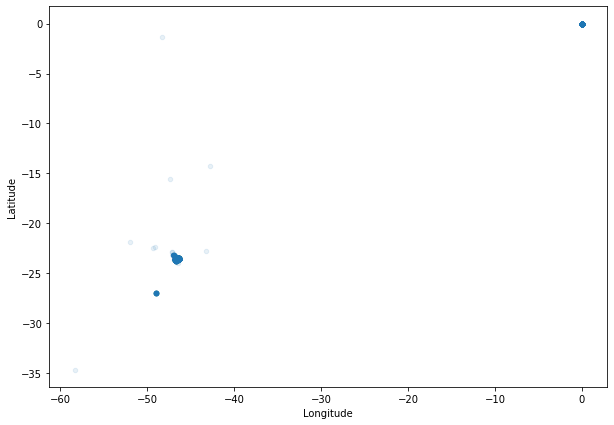

In [15]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, figsize=(10, 7))

It seems some data rows are out of the known limits of Sao Paolo city, lets clean them out

In [16]:
df = df[((df['Latitude'] > -24.0078) & (df['Latitude'] < -23.3573)) & ((df['Longitude'] > -46.8247) & (df['Longitude'] < -46.3664))]

#1.5.6 Re-check data distribution (scatterplot):

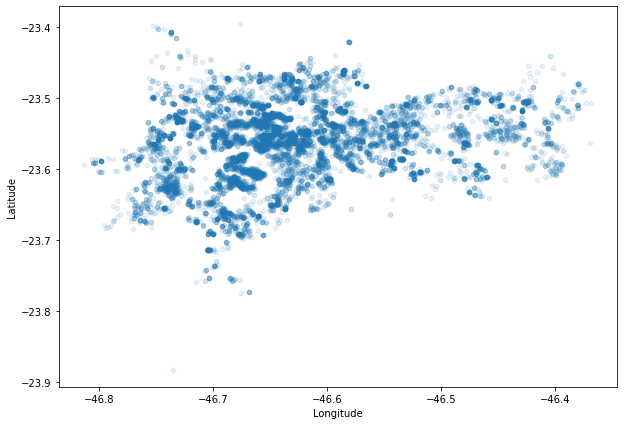

In [17]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, figsize=(10, 7))

It seems that data distribution corresponds to a geografical location that resembles to Sao Paolo City.

#1.5.7 Plot geographical data into Sao Paolo City limits

In [18]:
def make_map():
    fig, ax = plt.subplots()
    m = Basemap(projection='merc', llcrnrlat=-24, urcrnrlat=-23,
                llcrnrlon=-47, urcrnrlon=-46, resolution='i')
    m.ax = ax
    m.drawrivers()
    m.drawcounties()
    m.drawmapboundary()
    m.drawcoastlines()

    return fig, m

In [19]:
def drawcounties(ax, shapefile='/content/drive/MyDrive/IFSP/D2APR/shapefiles/CIDADES/BR_Municipios_2019'):
        shp = m.readshapefile(shapefile, 'county', drawbounds=True)
        for nshape, seg in enumerate(m.counties):
            poly = Polygon(seg, facecolor='0.75', edgecolor='k')
            ax.add_patch(poly)

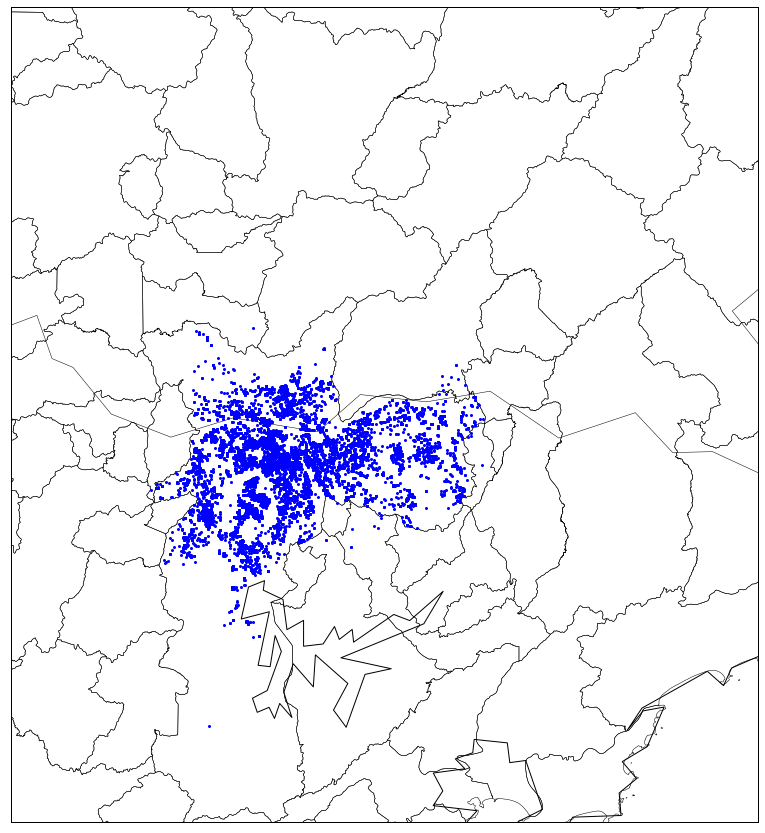

In [20]:
fig, m = make_map()
fig.set_size_inches(15,15)
x, y = m(df['Longitude'], df['Latitude'])
m.plot(x,y, 'bo', markersize=2)
drawcounties(m.ax)

There are still some data that seems to lie outside Sao Paulo city limits but lets keep these data.

#1.6 Data preparation
It is important to review all dataset attributes. 

#1.6.1 Extract City from District attribute
It is noticiable that district names includes city name as well. Lets extract city name into a separated attribute.

In [21]:
df[['District', 'City']] = df['District'].str.split('/', expand=True)
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,City
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.543138,-46.479486,São Paulo
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.550239,-46.480718,São Paulo
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.542818,-46.485665,São Paulo
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.547171,-46.483014,São Paulo
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent,apartment,-23.525025,-46.482436,São Paulo


#1.6.2 Inspect attributes

In [22]:
df['City'].unique()

array(['São Paulo'], dtype=object)

There´s only one value for City attribute, this attribute is irrelevant and can be removed.

In [23]:
df['District'].unique()

array(['Artur Alvim', 'Belém', 'Cangaíba', 'Carrão', 'Cidade Líder',
       'Cidade Tiradentes', 'Ermelino Matarazzo', 'Iguatemi',
       'Itaim Paulista', 'Itaquera', 'Jardim Helena', 'José Bonifácio',
       'Lajeado', 'Parque do Carmo', 'Penha', 'Ponte Rasa', 'Sapopemba',
       'São Lucas', 'São Mateus', 'São Miguel', 'São Rafael', 'Tatuapé',
       'Vila Curuçá', 'Vila Formosa', 'Vila Jacuí', 'Vila Matilde',
       'Vila Prudente', 'Cambuci', 'Campo Belo', 'Campo Grande',
       'Campo Limpo', 'Capão Redondo', 'Cidade Ademar', 'Cidade Dutra',
       'Cursino', 'Grajaú', 'Ipiranga', 'Itaim Bibi', 'Jabaquara',
       'Jardim Ângela', 'Jardim Paulista', 'Moema', 'Morumbi', 'Pedreira',
       'Sacomã', 'Santo Amaro', 'Saúde', 'Socorro', 'Vila Andrade',
       'Vila Mariana', 'Vila Sônia', 'Alto de Pinheiros', 'Anhanguera',
       'Brasilândia', 'Butantã', 'Cachoeirinha', 'Freguesia do Ó',
       'Jaguaré', 'Jaraguá', 'Lapa', 'Limão', 'Perdizes', 'Pinheiros',
       'Pirituba', 'Raposo

In [24]:
df['Property Type'].unique()

array(['apartment'], dtype=object)

There´s only one property type on this dataset so this attribute can be removed.

In [25]:
df['Swimming Pool'].unique()

array([0, 1])

In [26]:
df['Furnished'].unique()

array([0, 1])

In [27]:
df['Elevator'].unique()

array([0, 1])

In [28]:
df['Parking'].unique()

array([1, 2, 3, 4, 5, 6, 8, 9, 0, 7])

In [29]:
df['New'].unique()

array([0, 1])

In [30]:
df['Suites'].unique()

array([1, 3, 2, 4, 0, 5, 6])

In [31]:
df['Toilets'].unique()

array([2, 3, 4, 1, 5, 6, 7, 8])

#1.6.4 Negotiation types

There are two main subsets inside this dataset: real state for Sale and Rent. Those data sets can separated.

In [32]:
df['Negotiation Type'].unique()

array(['rent', 'sale'], dtype=object)

In [33]:
df_sale = df[(df[['Negotiation Type']] == 'sale').any(axis=1)]
df_sale.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,City
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena,sale,apartment,-23.552129,-46.692244,São Paulo
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena,sale,apartment,-23.551613,-46.699106,São Paulo
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena,sale,apartment,-23.547687,-46.692594,São Paulo
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena,sale,apartment,-23.552590,-46.691104,São Paulo
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena,sale,apartment,-23.553087,-46.697890,São Paulo


In [34]:
df_rent = df[(df[['Negotiation Type']] == 'rent').any(axis=1)]
df_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,City
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.543138,-46.479486,São Paulo
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.550239,-46.480718,São Paulo
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.542818,-46.485665,São Paulo
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.547171,-46.483014,São Paulo
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent,apartment,-23.525025,-46.482436,São Paulo


Base on the above data handling, there are some attibutes that are not needed as representing a single value: 'City', 'Property Type' and 'Negotiation Type'. Those attributes can be droped from each data frame.

In [35]:
df_rent = df_rent.drop(['City'], axis=1)
df_sale = df_sale.drop(['City'], axis=1)

In [36]:
df_rent = df_rent.drop(['Property Type'], axis=1)
df_sale = df_sale.drop(['Property Type'], axis=1)

In [37]:
df_sale = df_sale.drop(['Negotiation Type'], axis=1)
df_rent = df_rent.drop(['Negotiation Type'], axis=1)

In [38]:
df_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,-23.525025,-46.482436


In [39]:
df_sale.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena,-23.553087,-46.697890


#2.0 Looking for correlations

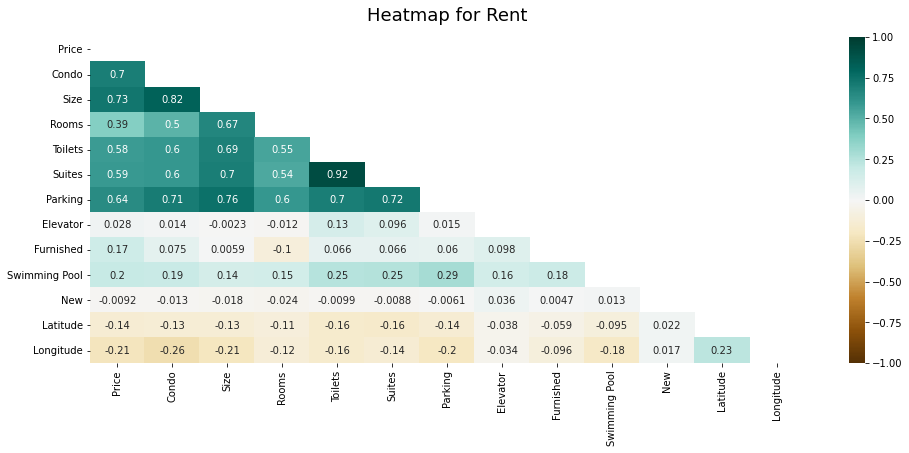

In [40]:
# plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_rent.corr(), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(df_rent.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Heatmap for Rent', fontdict={'fontsize':18}, pad=16);

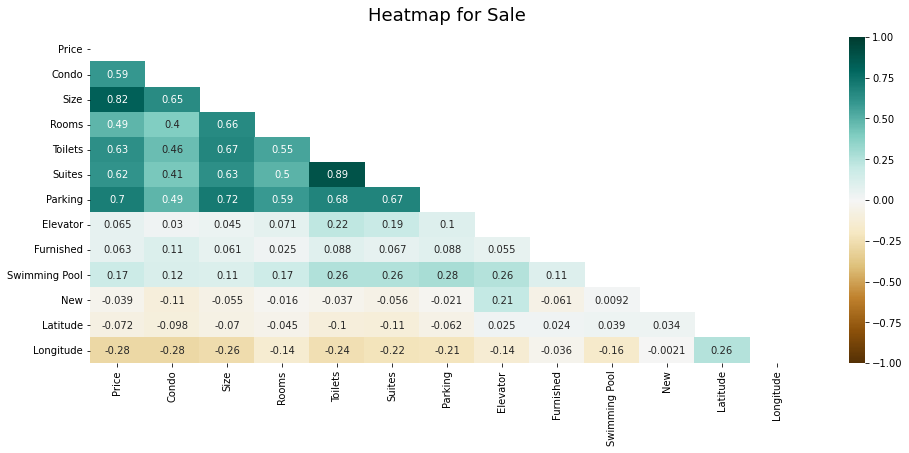

In [41]:
# plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_sale.corr(), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(df_sale.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Heatmap for Sale', fontdict={'fontsize':18}, pad=16);

In [42]:
numeric_attributes_rent = df_rent.columns.drop('District')
numeric_attributes_sale = df_sale.columns.drop('District')

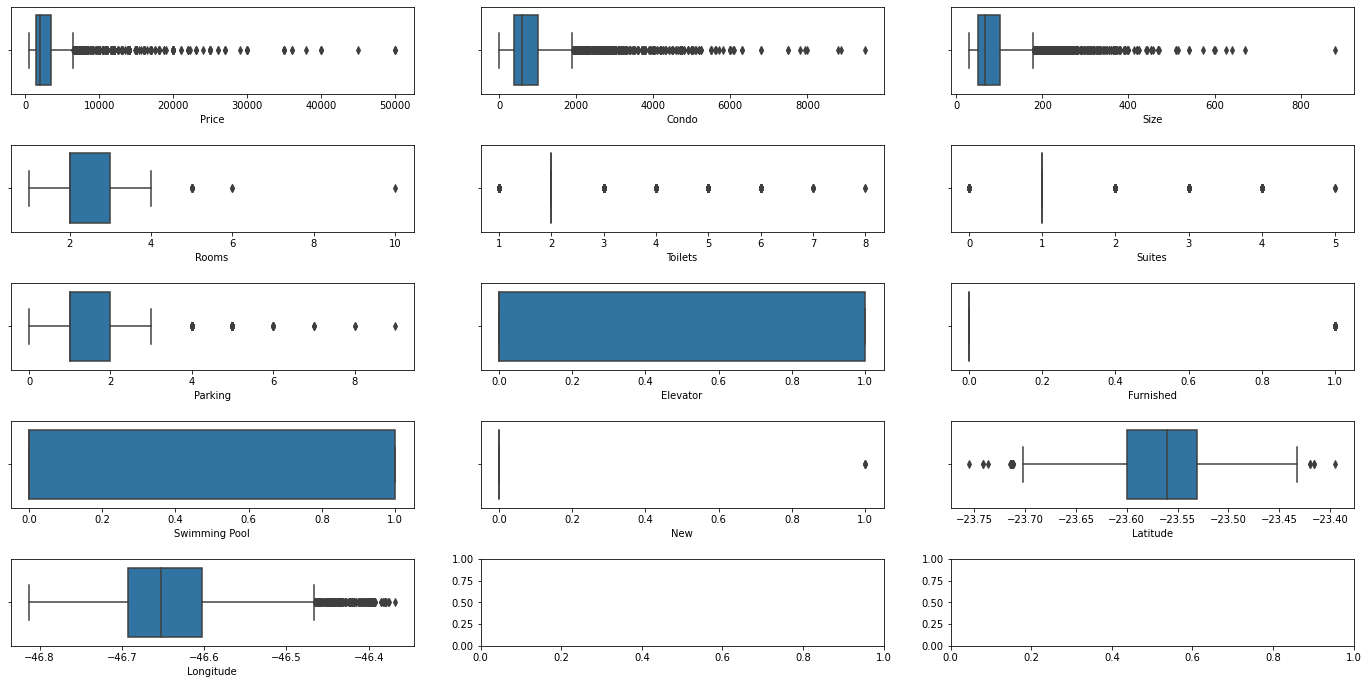

In [43]:
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(numeric_attributes_rent):
    row = i // 3
    col = i % 3
    sns.boxplot(data=df_rent, x=attr, ax=axes[row, col])

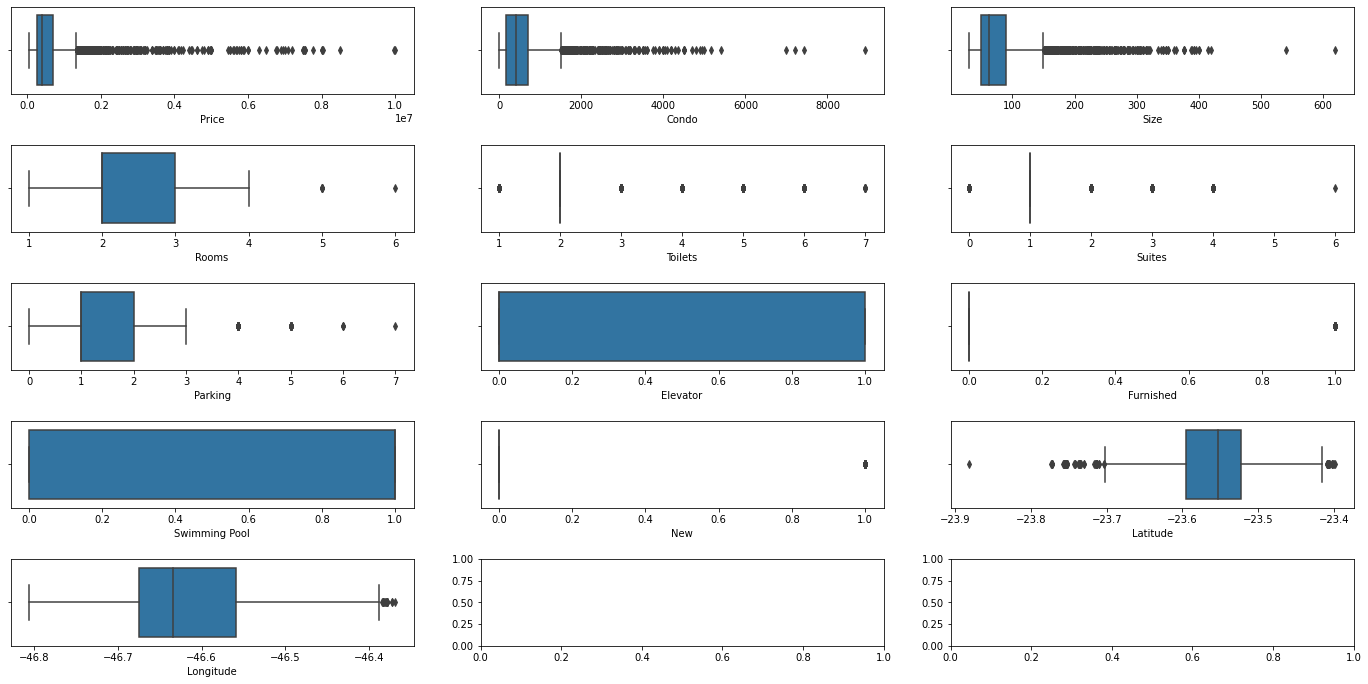

In [44]:
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(numeric_attributes_sale):
    row = i // 3
    col = i % 3
    sns.boxplot(data=df_sale, x=attr, ax=axes[row, col])

There seems to be several outliners based on Price attribute perspective. However, by checking Parking, Toilets, Suites and Rooms, it is also knew that those features increases the real estate value for rent and sale so lets keep this data for now.

#3.0 Train and Test data

Some data cleaning were performed previously this step on ML pipeline. Despite this fact, the operations performed where only to remove / fix obvious mistakes on data set and no tampering with values were done. Therefore, previous data cleaning operations should not interfere with the results and no relevant data snooping bias may be present.

In [45]:
from sklearn.model_selection import train_test_split

df_rent_train, df_rent_test = train_test_split(df_rent, test_size=0.2, random_state=42)
df_sale_train, df_sale_test = train_test_split(df_sale, test_size=0.2, random_state=42)

#3.1 Prepare the data

In [46]:
#rent dataset
df_rent_train_pre = df_rent_train.drop(columns=['Price'])
df_rent_train_target = df_rent_train['Price'].copy()

#sale dataset
df_sale_train_pre = df_sale_train.drop(columns=['Price'])
df_sale_train_target = df_sale_train['Price'].copy()

##3.1.1 Saving the datasets

In [47]:
# if you want to keep the reference for the row indices from the original dataset, remove the index=False
df_rent_train.to_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019_rent_train.csv', index=False)
df_rent_test.to_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019_rent_test.csv', index=False)

df_sale_train.to_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019_sale_train.csv', index=False)
df_sale_test.to_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019_sale_test.csv', index=False)

#3.2 Categorical attribute encoding

##3.2.1 Separate the numerical and categorical features

In [48]:
# numerical atributes rent
num_attributes_rent = df_rent_train.columns.drop('District')
# numerical atributes sale
num_attributes_sale = df_sale_train.columns.drop('District')

In [49]:
# categorical attributes
cat_attributes = ['District']

In [50]:
# separating the features rent
df_rent_train_num = df_rent_train[num_attributes_rent]
df_rent_train_cat = df_rent_train[cat_attributes]

# separating the features sale
df_sale_train_num = df_sale_train[num_attributes_sale]
df_sale_train_cat = df_sale_train[cat_attributes]

In [51]:
df_rent_train_pre['District'].value_counts()

Mooca              142
Moema              124
Vila Mariana       121
Morumbi            118
Vila Leopoldina    114
                  ... 
Lajeado              5
Sé                   5
Guaianazes           5
Parque do Carmo      3
Grajaú               2
Name: District, Length: 93, dtype: int64

In [52]:
df_sale_train_pre['District'].value_counts()

Casa Verde    119
Bom Retiro    114
Moema         102
Brooklin       97
Brás           92
             ... 
Vila Sônia     21
Iguatemi       17
Perus          15
Jaraguá        15
Medeiros        8
Name: District, Length: 96, dtype: int64

#3.2.2 Applying One Hot Encoding by Pandas.

In [53]:
# one hot encoding by pandas
df_rent_train_pre = pd.get_dummies(data=df_rent_train_pre, columns=['District'])
df_sale_train_pre = pd.get_dummies(data=df_sale_train_pre, columns=['District'])

##3.2.3 Saving the pre-processed training set

In [54]:
df_rent_train_pre_saving = df_rent_train_pre.copy()
df_rent_train_pre_saving['Price'] = df_rent_train_target
df_rent_train_pre_saving.to_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019_rent_train_pre.csv', index=False)

df_sale_train_pre_saving = df_sale_train_pre.copy()
df_sale_train_pre_saving['Price'] = df_sale_train_target
df_sale_train_pre_saving.to_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019_sale_train_pre.csv', index=False)
df_sale_train_pre_saving.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude,District_Alto de Pinheiros,District_Anhanguera,District_Aricanduva,District_Artur Alvim,District_Barra Funda,District_Bela Vista,District_Belém,District_Bom Retiro,District_Brasilândia,District_Brooklin,District_Brás,District_Butantã,District_Cachoeirinha,District_Cambuci,District_Campo Belo,District_Campo Grande,District_Campo Limpo,District_Cangaíba,District_Capão Redondo,District_Carrão,District_Casa Verde,District_Cidade Ademar,District_Cidade Dutra,District_Cidade Líder,District_Cidade Tiradentes,District_Consolação,District_Cursino,District_Ermelino Matarazzo,...,District_Penha,District_Perdizes,District_Perus,District_Pinheiros,District_Pirituba,District_Ponte Rasa,District_Raposo Tavares,District_República,District_Rio Pequeno,District_Sacomã,District_Santa Cecília,District_Santana,District_Santo Amaro,District_Sapopemba,District_Saúde,District_Socorro,District_São Domingos,District_São Lucas,District_São Mateus,District_São Miguel,District_São Rafael,District_Sé,District_Tatuapé,District_Tremembé,District_Tucuruvi,District_Vila Andrade,District_Vila Curuçá,District_Vila Formosa,District_Vila Guilherme,District_Vila Jacuí,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price
12999,280,50,2,1,0,1,0,0,0,0,-23.593101,-46.524288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,220000
6895,1980,148,3,4,3,3,0,0,0,0,-23.626665,-46.671215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1500000
6917,1400,154,3,5,3,3,1,0,1,0,-23.628099,-46.673906,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1850000
8488,450,128,2,1,0,1,0,0,0,0,-23.546323,-46.646603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,450000
12068,200,41,2,1,0,1,0,0,1,0,-23.535741,-46.595085,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,219900


#3.2.3 Prepare & Run LinearRegression model.

In [55]:
X_rent_train = df_rent_train_pre.values
y_rent_train = df_rent_train_target.values

X_sale_train = df_sale_train_pre.values
y_sale_train = df_sale_train_target.values

In [56]:
from sklearn.linear_model import LinearRegression

lin_reg_rent = LinearRegression()  # default hyperparameters
lin_reg_sale = LinearRegression()  # default hyperparameters

# training
lin_reg_rent.fit(X_rent_train, y_rent_train)
lin_reg_sale.fit(X_sale_train, y_sale_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
y_rent_train_pred = lin_reg_rent.predict(X_rent_train)
y_sale_train_pred = lin_reg_sale.predict(X_sale_train)

In [58]:
r2_score = lin_reg_rent.score(X_rent_train, y_rent_train)
print(f'R2 for rent= {r2_score}')

R2 for rent= 0.6891968761164249


In [59]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_rent_train, y_rent_train_pred, squared=False)
print(f'RMSE for rent = {rmse}')

RMSE for rent = 2020.8044990659876


In [60]:
r2_score = lin_reg_sale.score(X_sale_train, y_sale_train)
print(f'R2 for sale= {r2_score}')

R2 for sale= 0.81636771103533


In [61]:
rmse = mean_squared_error(y_sale_train, y_sale_train_pred, squared=False)
print(f'RMSE for sale = {rmse}')

RMSE for sale = 333550.2698989571


Text(0.5, 1.0, 'Price value for rent - Prediction vs Real')

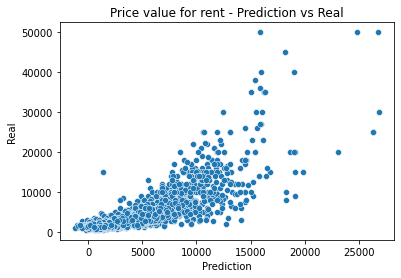

In [62]:
sns.scatterplot(x=y_rent_train_pred, y=y_rent_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price value for rent - Prediction vs Real')

Text(0.5, 1.0, 'Price value for sale - Prediction vs Real')

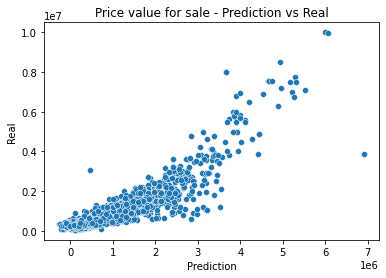

In [63]:
sns.scatterplot(x=y_sale_train_pred, y=y_sale_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price value for sale - Prediction vs Real')

In [64]:
residual_rent = y_rent_train - y_rent_train_pred
residual_sale = y_sale_train - y_sale_train_pred

Text(0.5, 1.0, 'Rent value - Prediction vs Residual')

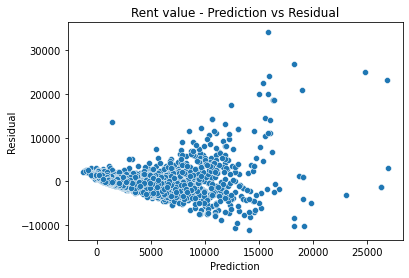

In [65]:

sns.scatterplot(x=y_rent_train_pred, y=residual_rent)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Rent value - Prediction vs Residual')

Text(0.5, 1.0, 'Sale value - Prediction vs Residual')

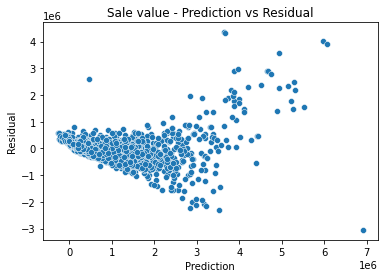

In [66]:
sns.scatterplot(x=y_sale_train_pred, y=residual_sale)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Sale value - Prediction vs Residual')

Both predictions do not meet the homoscedasticity. Another look on attributes sets may be needed. Even though, **R2 for Sales prediction seems pretty good, 0.947 which is a very good score**.

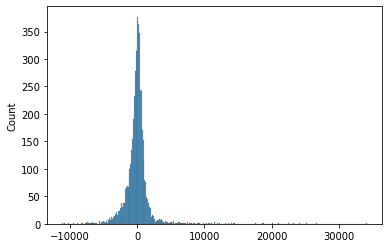

In [67]:
sns.histplot(residual_rent)

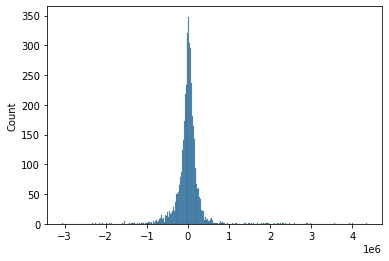

In [68]:
sns.histplot(residual_sale)

#3.3 Conclusion for first model
The prediction model for **Rent Market** seems better than model for **Sale Market**. It is a fact, though, that both models underfit the training set and by visual inspection of prediction vs residual, it is clear that they also lacks **homoscedasticity**.
Residual for both seems to follow a normal distribution. Lets try to apply some additional techniques on data sets ahead.

#4 Data preparation review
As the first approach does not seems to result in a good model, lets try some techniques to enhance our model. One of the approach is to remove some ouliers. Another approach is to extract new attributes based on known information. By this point forward, in order to avoid dupplication of the effort and make the analysis simplier, lets also focus our attention on a single market, the **Rent Market**. This decision is also based on the fact that the worst model based on previous result was the model for Rent Market.

##4.1 Load the data

As the pre-processed train data set is saved, lets reload it.

In [69]:
df_rent_train_pre = pd.read_csv('/content/drive/MyDrive/IFSP/D2APR/SP/sao-paulo-dataset/sao-paulo-properties-april-2019_rent_train_pre.csv')
df_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude,District_Alto de Pinheiros,District_Anhanguera,District_Aricanduva,District_Artur Alvim,District_Barra Funda,District_Bela Vista,District_Belém,District_Bom Retiro,District_Brasilândia,District_Brooklin,District_Brás,District_Butantã,District_Cachoeirinha,District_Cambuci,District_Campo Belo,District_Campo Grande,District_Campo Limpo,District_Cangaíba,District_Capão Redondo,District_Carrão,District_Casa Verde,District_Cidade Ademar,District_Cidade Dutra,District_Cidade Líder,District_Cidade Tiradentes,District_Consolação,District_Cursino,District_Ermelino Matarazzo,...,District_Parque do Carmo,District_Pedreira,District_Penha,District_Perdizes,District_Pinheiros,District_Pirituba,District_Ponte Rasa,District_Raposo Tavares,District_República,District_Rio Pequeno,District_Sacomã,District_Santa Cecília,District_Santana,District_Santo Amaro,District_Sapopemba,District_Saúde,District_Socorro,District_São Lucas,District_São Mateus,District_São Miguel,District_São Rafael,District_Sé,District_Tatuapé,District_Tremembé,District_Tucuruvi,District_Vila Andrade,District_Vila Curuçá,District_Vila Formosa,District_Vila Guilherme,District_Vila Jacuí,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price
0,1800,150,3,3,2,3,0,0,1,0,-23.551586,-46.698023,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6000
1,3200,230,4,3,2,3,0,0,0,0,-23.560253,-46.699183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000
2,480,100,2,2,0,1,1,0,0,0,-23.568037,-46.593205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2500
3,495,36,1,1,0,1,0,0,1,0,-23.537947,-46.652422,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2750
4,1511,118,3,2,1,3,1,0,0,0,-23.562526,-46.647866,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4000


##4.1 Outliers
Lets remove the values that are greater than 1.5 times quantile distance + mean.

In [70]:
iqr_rent = round((1.5 * (df_rent_train_pre['Price'].quantile(.75) - df_rent_train_pre['Price'].quantile(.25))) + df_rent_train_pre['Price'].mean(),2)
df_rent_train_pre = df_rent_train_pre[df_rent_train_pre['Price'] < iqr_rent]

In [71]:
iqr_rent

6123.11

##4.2 Add new attributes
Two possibilities of derived attributes that might result on good descriptive attributes are a ratio between toilets/rooms and also the size/rooms. Also, it is known that one attribute that is widely used in real state market base price comparision is the price per square meter of a property.

In [72]:
df_rent_train_pre['Price sqrm'] = round(df_rent_train_pre['Price'] / df_rent_train_pre['Size'],2)
df_rent_train_pre['Toilets per room'] = df_rent_train_pre['Toilets'] / df_rent_train_pre['Rooms']
df_rent_train_pre['Size per room'] = df_rent_train_pre['Size'] / df_rent_train_pre['Rooms']
df_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude,District_Alto de Pinheiros,District_Anhanguera,District_Aricanduva,District_Artur Alvim,District_Barra Funda,District_Bela Vista,District_Belém,District_Bom Retiro,District_Brasilândia,District_Brooklin,District_Brás,District_Butantã,District_Cachoeirinha,District_Cambuci,District_Campo Belo,District_Campo Grande,District_Campo Limpo,District_Cangaíba,District_Capão Redondo,District_Carrão,District_Casa Verde,District_Cidade Ademar,District_Cidade Dutra,District_Cidade Líder,District_Cidade Tiradentes,District_Consolação,District_Cursino,District_Ermelino Matarazzo,...,District_Perdizes,District_Pinheiros,District_Pirituba,District_Ponte Rasa,District_Raposo Tavares,District_República,District_Rio Pequeno,District_Sacomã,District_Santa Cecília,District_Santana,District_Santo Amaro,District_Sapopemba,District_Saúde,District_Socorro,District_São Lucas,District_São Mateus,District_São Miguel,District_São Rafael,District_Sé,District_Tatuapé,District_Tremembé,District_Tucuruvi,District_Vila Andrade,District_Vila Curuçá,District_Vila Formosa,District_Vila Guilherme,District_Vila Jacuí,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price,Price sqrm,Toilets per room,Size per room
0,1800,150,3,3,2,3,0,0,1,0,-23.551586,-46.698023,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6000,40.00,1.000000,50.000000
1,3200,230,4,3,2,3,0,0,0,0,-23.560253,-46.699183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000,21.74,0.750000,57.500000
2,480,100,2,2,0,1,1,0,0,0,-23.568037,-46.593205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2500,25.00,1.000000,50.000000
3,495,36,1,1,0,1,0,0,1,0,-23.537947,-46.652422,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2750,76.39,1.000000,36.000000
4,1511,118,3,2,1,3,1,0,0,0,-23.562526,-46.647866,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4000,33.90,0.666667,39.333333


##4.3 Check correlations

In order to check cor correlations, we need to remove the categorical columns added before from the comparision.

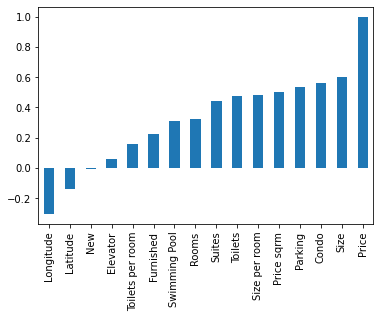

In [73]:
df_rent_train_pre.loc[:, ~df_rent_train_pre.columns.str.startswith('District')].corr()['Price'].sort_values().plot.bar();

It seems that attributes New and Elevator have little influence on Price that is the focus of this study. Those variables can be propped when dealing with real states for rent.

In [74]:
df_rent_train_pre = df_rent_train_pre.drop(['New', 'Elevator'], axis=1)
df_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Furnished,Swimming Pool,Latitude,Longitude,District_Alto de Pinheiros,District_Anhanguera,District_Aricanduva,District_Artur Alvim,District_Barra Funda,District_Bela Vista,District_Belém,District_Bom Retiro,District_Brasilândia,District_Brooklin,District_Brás,District_Butantã,District_Cachoeirinha,District_Cambuci,District_Campo Belo,District_Campo Grande,District_Campo Limpo,District_Cangaíba,District_Capão Redondo,District_Carrão,District_Casa Verde,District_Cidade Ademar,District_Cidade Dutra,District_Cidade Líder,District_Cidade Tiradentes,District_Consolação,District_Cursino,District_Ermelino Matarazzo,District_Freguesia do Ó,District_Grajaú,...,District_Perdizes,District_Pinheiros,District_Pirituba,District_Ponte Rasa,District_Raposo Tavares,District_República,District_Rio Pequeno,District_Sacomã,District_Santa Cecília,District_Santana,District_Santo Amaro,District_Sapopemba,District_Saúde,District_Socorro,District_São Lucas,District_São Mateus,District_São Miguel,District_São Rafael,District_Sé,District_Tatuapé,District_Tremembé,District_Tucuruvi,District_Vila Andrade,District_Vila Curuçá,District_Vila Formosa,District_Vila Guilherme,District_Vila Jacuí,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Price,Price sqrm,Toilets per room,Size per room
0,1800,150,3,3,2,3,0,1,-23.551586,-46.698023,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6000,40.00,1.000000,50.000000
1,3200,230,4,3,2,3,0,0,-23.560253,-46.699183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000,21.74,0.750000,57.500000
2,480,100,2,2,0,1,0,0,-23.568037,-46.593205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2500,25.00,1.000000,50.000000
3,495,36,1,1,0,1,0,1,-23.537947,-46.652422,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2750,76.39,1.000000,36.000000
4,1511,118,3,2,1,3,0,0,-23.562526,-46.647866,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4000,33.90,0.666667,39.333333


#5 Train ML algorithm

Lets separate the independent attributes from dependent attribute that is the focus of the prediction:

In [75]:
#rent dataset
df_rent_train_target = df_rent_train_pre['Price'].copy()
df_rent_train_pre = df_rent_train_pre.drop(columns=['Price'])

In [76]:
X_train = df_rent_train_pre.values
y_train = df_rent_train_target.values

##5.1 Training the models

In [77]:
linear_regressor = LinearRegression()  # default parameters
linear_regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##5.2 Evaluation of the prediction model

In [78]:
y_train_pred = linear_regressor.predict(X_train)

In [79]:
r2_score = linear_regressor.score(X_train, y_train)
print(f'R² = {r2_score}')

R² = 0.8867276593597031


In [80]:
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'RMSE = {rmse}')

RMSE = 411.268901132778


The R2 score seems much better than previous calculation. The second model including the derived attributes and the removal of some irrelevant attributes resulted in a score of 0.887 against the previous score of 0.689, which is an expressive increase.
The mean squared error dropped from 2020 to 411 which is also a relevant enhancement.

Text(0.5, 1.0, 'Rent value - Prediction vs Real')

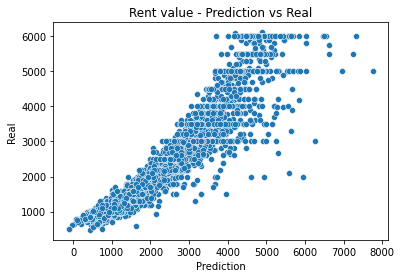

In [81]:
sns.scatterplot(x=y_train_pred, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Rent value - Prediction vs Real')

In [82]:
residual = y_train - y_train_pred

Text(0.5, 1.0, 'Rent value - Prediction vs Residual')

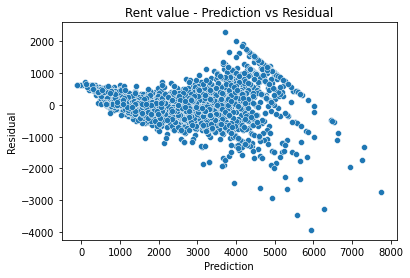

In [83]:
sns.scatterplot(x=y_train_pred, y=residual)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Rent value - Prediction vs Residual')

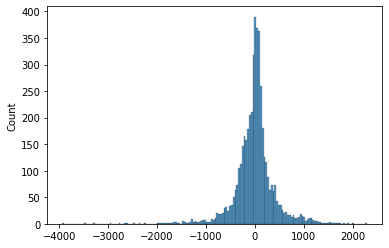

In [84]:
sns.histplot(residual)

#5.3 Conclusion for second model
Although the expressive enhancement on the prediction model, it still underfit the training set. By visual inspection of prediction vs residual, it is clear that is also lacks **homoscedasticity**. The residual still seems to follow a normal distribution histogram.

Lets apply some other techniques on **Rent Market** data set to try to enhance the prediction model ahead.

#6 Atributes Scalling
In order to apply attribute scalling, it is needed to keep appart dummy variables from numeric variables.

In [136]:
numeric_variables = df_rent_train_pre.loc[:, ~df_rent_train_pre.columns.str.startswith('District')].columns;
dummy_variables  = df_rent_train_pre.loc[:, df_rent_train_pre.columns.str.startswith('District')].columns;

X_train_numeric = df_rent_train_pre[numeric_variables].values
X_train_dummy = df_rent_train_pre[dummy_variables].values

In [137]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# learn the median and IQR for each feature from our training (numeric) set
scaler.fit(X_train_numeric)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [138]:
print(f'center: {scaler.center_}\n')

center: [561.5         65.           2.           2.           1.
   1.           0.           0.         -23.557146   -46.64481105
  26.945        1.          32.        ]



In [139]:
# aplying feature scaling
X_train_numeric_norm = scaler.transform(X_train_numeric)

In [140]:
# our final normalized training set
X_train = np.hstack((X_train_numeric_norm, X_train_dummy))

In [141]:

X_train

array([[ 2.63510638,  2.23684211,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.61382979,  4.34210526,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.17340426,  0.92105263,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.68404255, -0.60526316,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08191489, -0.13157895,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34361702, -0.71052632,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

##6.1 Train Algorithm

In [142]:
# we already have X_train
y_train = df_rent_train_target.values
y_train

array([6000, 5000, 2500, ...,  660, 1250, 1100])

###6.1.1 Linear Regression

In [151]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # default parameters
linear_regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

###6.1.2 Decision Tree Regression

In [152]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor()  # default hyperparameters
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

##6.2 Evaluating the training data set

###6.2.1 Linear Regression

In [153]:
#prediction
y_train_pred_lin = linear_regressor.predict(X_train)


In [154]:
#evaluation
r2_score = linear_regressor.score(X_train, y_train)
print(f'R² linear regression = {r2_score}')

R² linear regression = 0.8867276709494848


In [155]:
from sklearn.metrics import mean_squared_error

lin_reg_rmse = mean_squared_error(y_train, y_train_pred_lin, squared=False)
print(f'RMSE = {lin_reg_rmse}')

RMSE = 411.2688800927037


###6.2.1.1 Visual Analysis

Text(0.5, 1.0, 'Price - Prediction vs Real - Linear Regression')

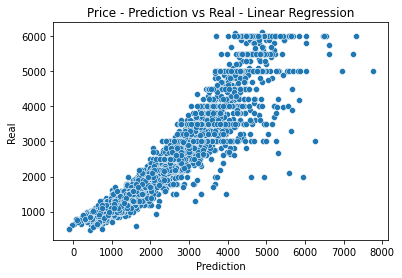

In [156]:
sns.scatterplot(x=y_train_pred_lin, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price - Prediction vs Real - Linear Regression')

Text(0.5, 1.0, 'Price - Prediction vs Residual - Linear Regression')

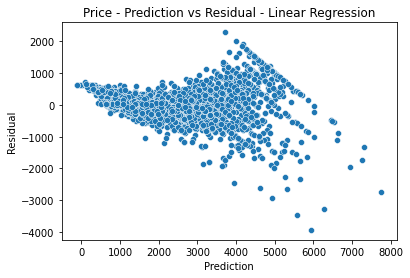

In [157]:
residual_lin_reg = y_train - y_train_pred_lin

sns.scatterplot(x=y_train_pred_lin_reg, y=residual_lin_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Price - Prediction vs Residual - Linear Regression')

###6.2.1.2 Evaluation
Based on these results, the Attribute scalling technique did not result in a perceptive enhancement on Linear Regression model. It is just slighly better, with R2 of 0.88672767 against 0.88672765, a difference on 8th decimal only. The same happens for RMS that increased to 411.26888 against 411.26890 previously.

###6.2.2 Decision Tree Regression

In [159]:
#prediction
y_train_pred_tree_reg = tree_regressor.predict(X_train)

In [160]:
#evaluation
from sklearn.metrics import r2_score

tree_reg_r2 = r2_score(y_train, y_train_pred_tree_reg)
print(f'R² decision tree regression = {tree_reg_r2}')

R² decision tree regression = 1.0


In [161]:
from sklearn.metrics import mean_squared_error

tree_reg_rmse = mean_squared_error(y_train, y_train_pred_tree_reg, squared=False)
print(f'RMSE = {tree_reg_rmse}')

RMSE = 0.0


###6.2.2.1 Visual Analysis

Text(0.5, 1.0, 'Price - Prediction vs Real - Decision Tree Regression')

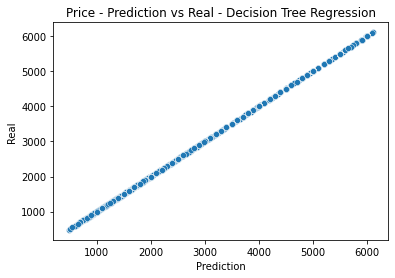

In [169]:
sns.scatterplot(x=y_train_pred_tree_reg, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Price - Prediction vs Real - Decision Tree Regression')

Text(0.5, 1.0, 'Price - Prediction vs Residual |')

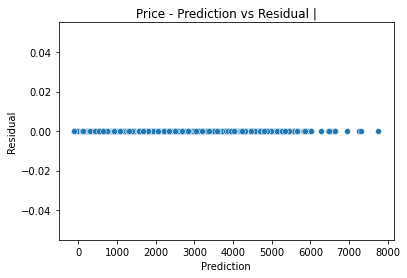

In [170]:
residual_tree_reg = y_train - y_train_pred_tree_reg

sns.scatterplot(x=y_train_pred_lin_reg, y=residual_tree_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Price - Prediction vs Residual |')

###6.2.2.2 Evaluation
It seems that Decision Tree Regression overfits the trainning dataset. A cross validation is needed.

#6.3 Cross Validation

##6.3.1 Linear Regression

In [164]:
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_neg_mse_scores = cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

lin_rmse_scores = np.sqrt(-lin_neg_mse_scores)

In [165]:
display_scores(lin_rmse_scores)

Scores: [485.64384866 464.41317308 377.20627348 410.68470623 419.4898858
 368.58055915 395.80854007 398.75308689 441.281585   443.47376269]
Mean: 420.5335421052725
Standard deviation: 35.89105240225517


##6.3.2 Decision Tree Regression

In [166]:

from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=42)
tree_neg_mse_scores = cross_val_score(tree_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

tree_rmse_scores = np.sqrt(-tree_neg_mse_scores)

In [167]:
# printing function
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [168]:
display_scores(tree_rmse_scores)

Scores: [163.36477168 194.49934102 125.65457366 129.26947124 147.97516827
 111.95514008 101.13332365 127.70313662 154.44428127 143.81074251]
Mean: 139.98099499896986
Standard deviation: 25.63616682765679


##6.3.3 Cross Validation conclusions

It seems that the **Decision Tree Regression** looks better than **Linear Regression** in this data set. By using the splitting into 10 folds, it was possible to get the understanding that Decision Tree Regression has a mean RMSE of 140 against the RMSE for Linear Regression of 420.

#7 Automate data processing

##7.1 Reload original dataset

In [176]:
df_rent_numeric = df_rent_train.loc[:, ~df_rent_train.columns.str.startswith('District')];
df_rent_dummy  = df_rent_train.loc[:, df_rent_train.columns.str.startswith('District')];

In [177]:
df_rent_numeric.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
10844,6000,1800,150,3,3,2,3,0,0,1,0,-23.551586,-46.698023
10959,5000,3200,230,4,3,2,3,0,0,0,0,-23.560253,-46.699183
5340,2500,480,100,2,2,0,1,1,0,0,0,-23.568037,-46.593205
2546,2750,495,36,1,1,0,1,0,0,1,0,-23.537947,-46.652422
9103,4000,1511,118,3,2,1,3,1,0,0,0,-23.562526,-46.647866


In [178]:
df_rent_dummy.head()

,District
10844,Alto de Pinheiros
10959,Pinheiros
5340,Mooca
2546,Santa Cecília
9103,Bela Vista


##7.2 Transformer

In [179]:
# template to create an own estimation
from sklearn.base import BaseEstimator, TransformerMixin


class NameOfYourTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        return None  # return the transformed data instead of None

In [180]:
# get the integer index of each attribute/column:
for index, column_name in enumerate(df_rent_numeric.columns):
    print(f'{index} = {column_name}')

0 = Price
1 = Condo
2 = Size
3 = Rooms
4 = Toilets
5 = Suites
6 = Parking
7 = Elevator
8 = Furnished
9 = Swimming Pool
10 = New
11 = Latitude
12 = Longitude


In [181]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

price_col_idx = 0
size_col_idx = 2
rooms_col_idx = 3
toilets_col_idx = 4

class HousingFeatEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        n_rows = X.shape[0]
        
        # creating the new features
        toilets_per_room = X[:, toilets_col_idx] / X[:, rooms_col_idx]
        size_per_room = X[:, size_col_idx] / X[:, rooms_col_idx]
        price_sqrm = X[:, price_col_idx] / X[:, size_col_idx]
        
        # to concatenate the new arrays as columns in our feature matrix, we need to reshape first
        toilets_per_room = toilets_per_room.reshape((n_rows, 1))
        size_per_room = size_per_room.reshape((n_rows, 1))
        price_sqrm = price_sqrm.reshape((n_rows, 1))
        
        # concatenating the new features into the feature matrix X
        X_out = np.hstack((X, toilets_per_room, size_per_room, price_sqrm))
        
        return X_out

In [182]:
feat_engineer = HousingFeatEngineering()

housing_train_num_new_feats = feat_engineer.transform(df_rent_numeric.values)  # we need to convert it to numpy first
housing_train_num_new_feats

array([[6.00000000e+03, 1.80000000e+03, 1.50000000e+02, ...,
        1.00000000e+00, 5.00000000e+01, 4.00000000e+01],
       [5.00000000e+03, 3.20000000e+03, 2.30000000e+02, ...,
        7.50000000e-01, 5.75000000e+01, 2.17391304e+01],
       [2.50000000e+03, 4.80000000e+02, 1.00000000e+02, ...,
        1.00000000e+00, 5.00000000e+01, 2.50000000e+01],
       ...,
       [6.60000000e+02, 2.40000000e+02, 4.20000000e+01, ...,
        1.00000000e+00, 2.10000000e+01, 1.57142857e+01],
       [1.25000000e+03, 6.00000000e+02, 6.00000000e+01, ...,
        1.00000000e+00, 3.00000000e+01, 2.08333333e+01],
       [1.10000000e+03, 4.00000000e+02, 3.80000000e+01, ...,
        1.00000000e+00, 1.90000000e+01, 2.89473684e+01]])

In [183]:
housing_train_num_new_feats.shape

(5218, 16)

In [184]:
# show the new feats
housing_train_num_new_feats[:, -3:]

array([[ 1.        , 50.        , 40.        ],
       [ 0.75      , 57.5       , 21.73913043],
       [ 1.        , 50.        , 25.        ],
       ...,
       [ 1.        , 21.        , 15.71428571],
       [ 1.        , 30.        , 20.83333333],
       [ 1.        , 19.        , 28.94736842]])

##7.3 Attribute scalling

In [185]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(df_rent_numeric)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [186]:
df_rent_numeric_scaled = scaler.transform(df_rent_numeric)
df_rent_numeric_scaled

array([[ 2.00000000e+00,  2.00000000e+00,  1.64000000e+00, ...,
         0.00000000e+00,  1.25108792e-01, -4.99625052e-01],
       [ 1.50000000e+00,  4.33333333e+00,  3.24000000e+00, ...,
         0.00000000e+00, -4.99301775e-04, -5.12393938e-01],
       [ 2.50000000e-01, -2.00000000e-01,  6.40000000e-01, ...,
         0.00000000e+00, -1.13312516e-01,  6.54172605e-01],
       ...,
       [-6.70000000e-01, -6.00000000e-01, -5.20000000e-01, ...,
         0.00000000e+00,  7.34233767e-01,  3.00057543e+00],
       [-3.75000000e-01,  0.00000000e+00, -1.60000000e-01, ...,
         0.00000000e+00, -1.65984940e+00, -3.55208949e-01],
       [-4.50000000e-01, -3.33333333e-01, -6.00000000e-01, ...,
         0.00000000e+00, -1.63958746e+00, -1.17920939e+00]])

##7.4 Categorical attribute encoding

In [189]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
df_rent_dummy_1hot = encoder.fit_transform(df_rent_dummy)
df_rent_dummy_1hot

<5218x93 sparse matrix of type '<class 'numpy.float64'>'
	with 5218 stored elements in Compressed Sparse Row format>

In [190]:
df_rent_dummy_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [191]:
encoder.categories_

[array(['Alto de Pinheiros', 'Anhanguera', 'Aricanduva', 'Artur Alvim',
        'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro', 'Brasilândia',
        'Brooklin', 'Brás', 'Butantã', 'Cachoeirinha', 'Cambuci',
        'Campo Belo', 'Campo Grande', 'Campo Limpo', 'Cangaíba',
        'Capão Redondo', 'Carrão', 'Casa Verde', 'Cidade Ademar',
        'Cidade Dutra', 'Cidade Líder', 'Cidade Tiradentes', 'Consolação',
        'Cursino', 'Ermelino Matarazzo', 'Freguesia do Ó', 'Grajaú',
        'Guaianazes', 'Iguatemi', 'Ipiranga', 'Itaim Bibi',
        'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaguaré', 'Jaraguá',
        'Jardim Helena', 'Jardim Paulista', 'Jardim Ângela', 'Jaçanã',
        'José Bonifácio', 'Lajeado', 'Lapa', 'Liberdade', 'Limão',
        'Mandaqui', 'Medeiros', 'Moema', 'Mooca', 'Morumbi', 'Pari',
        'Parque do Carmo', 'Pedreira', 'Penha', 'Perdizes', 'Pinheiros',
        'Pirituba', 'Ponte Rasa', 'Raposo Tavares', 'República',
        'Rio Pequeno', 'Sacomã', '

##7.5 Preprocessing pipelines

###7.5.1 Numerical Data

In [192]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

num_pipeline = Pipeline([
    ('feat_engineering', HousingFeatEngineering()),
    ('robust_scaler', RobustScaler())
])

In [195]:
df_rent_numeric_preprocessed = num_pipeline.fit_transform(df_rent_numeric.values)

In [196]:
df_rent_numeric_preprocessed

array([[ 2.        ,  2.        ,  1.64      , ...,  0.        ,
         0.89189189,  0.71186248],
       [ 1.5       ,  4.33333333,  3.24      , ..., -0.75      ,
         1.2972973 , -0.38280934],
       [ 0.25      , -0.2       ,  0.64      , ...,  0.        ,
         0.89189189, -0.18733223],
       ...,
       [-0.67      , -0.6       , -0.52      , ...,  0.        ,
        -0.67567568, -0.74397658],
       [-0.375     ,  0.        , -0.16      , ...,  0.        ,
        -0.18918919, -0.43710854],
       [-0.45      , -0.33333333, -0.6       , ...,  0.        ,
        -0.78378378,  0.04929796]])

In [198]:
df_rent_numeric.shape

(5218, 13)

In [197]:
df_rent_numeric_preprocessed.shape

(5218, 16)

###7.5.2 Categorical Data

In [199]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])

In [200]:
df_rent_dummy_preprocessed = cat_pipeline.fit_transform(df_rent_dummy)

In [201]:
df_rent_dummy_preprocessed.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [202]:
np.all(df_rent_dummy_preprocessed.toarray() == df_rent_dummy_1hot)

True

###7.5.3 Column Transform

In [222]:
# numerical atributes rent
num_attributes = df_rent_train.columns.drop('District')
# categorical attributes
cat_attributes = ['District']

In [223]:
num_attributes

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming Pool', 'New', 'Latitude',
       'Longitude'],
      dtype='object')

In [224]:
cat_attributes

['District']

In [225]:
df_rent_train.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
10844,6000,1800,150,3,3,2,3,0,0,1,0,Alto de Pinheiros,-23.551586,-46.698023
10959,5000,3200,230,4,3,2,3,0,0,0,0,Pinheiros,-23.560253,-46.699183
5340,2500,480,100,2,2,0,1,1,0,0,0,Mooca,-23.568037,-46.593205
2546,2750,495,36,1,1,0,1,0,0,1,0,Santa Cecília,-23.537947,-46.652422
9103,4000,1511,118,3,2,1,3,1,0,0,0,Bela Vista,-23.562526,-46.647866


In [237]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('feat_engineering', HousingFeatEngineering()),
    ('robust_scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])


# (name, transformer, columns)
preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attributes.values),
    ('categorical', cat_pipeline, cat_attributes)
])

In [238]:
df_rent_pre_npy = preprocessed_pipeline.fit_transform(df_rent_train)

TypeError: ignored